In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io
import glob
import albumentations as A


# Root directory of the project
ROOT_DIR = os.path.abspath(os.getcwd())

# Import Mask RCNN 
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn import stats_utils

import Monuseg_dist

%matplotlib inline 
%load_ext autoreload
%autoreload 2

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

MONUSEG_DIR = os.path.join(ROOT_DIR, "datasets\\Monuseg_dist")
config = Monuseg_dist.MonusegDIST_H_InferenceConfig()


c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' 

In [2]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [3]:
# Load dataset - 
subset = "val"
dataset_dir = os.path.join(MONUSEG_DIR, subset)
image_dir = os.path.join(dataset_dir, "tissue_images")
image_ids = os.listdir(image_dir)
print("Found {} images in {}".format(len(image_ids), image_dir))


dataset = Monuseg_dist.MonusegDISTDataset("UNET")
dataset.add_class(source = "Monuseg", class_id =  1, class_name = "nucleus")

# Fill with the samples
i = 0
for _id in image_ids:
    name,_ = os.path.splitext(_id)
    if i <= len(image_ids):
        dataset.add_image(source = "Monuseg",
                                image_id = name,
                                path = os.path.join(image_dir, _id))
    i+=1    

    
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Found 14 images in C:\Users\User\GitHub\Improved Mask R-CNN\datasets\Monuseg_dist\val\tissue_images
Image Count: 14
Class Count: 2
  0. BG                                                
  1. nucleus                                           


In [4]:
DEVICE = "/gpu:0"
TEST_MODE = "inference"

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
    
weights_path = r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_pannuke_1x120210630T0837\mask_rcnn_monuseg_dist_gt_pannuke_1x1_0050.h5"
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

# Create results folder:
results_path = os.path.join(os.path.dirname(weights_path), "Detections")
if not os.path.isdir(results_path):
    os.mkdir(results_path)
print(results_path)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_pannuke_1x120210630T0837\mask_rcnn_monuseg_dist_gt_pannuke_1x1_0050.h5
Re-starting from epoch 50
C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_pannuke_1x120210630T0837\Detections


Running detection...
Processing 1 images
image                    shape: (1000, 1000, 5)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 5)    min: -176.31887  max:  239.81833  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
Done detecting...
(1000, 1000, 515)


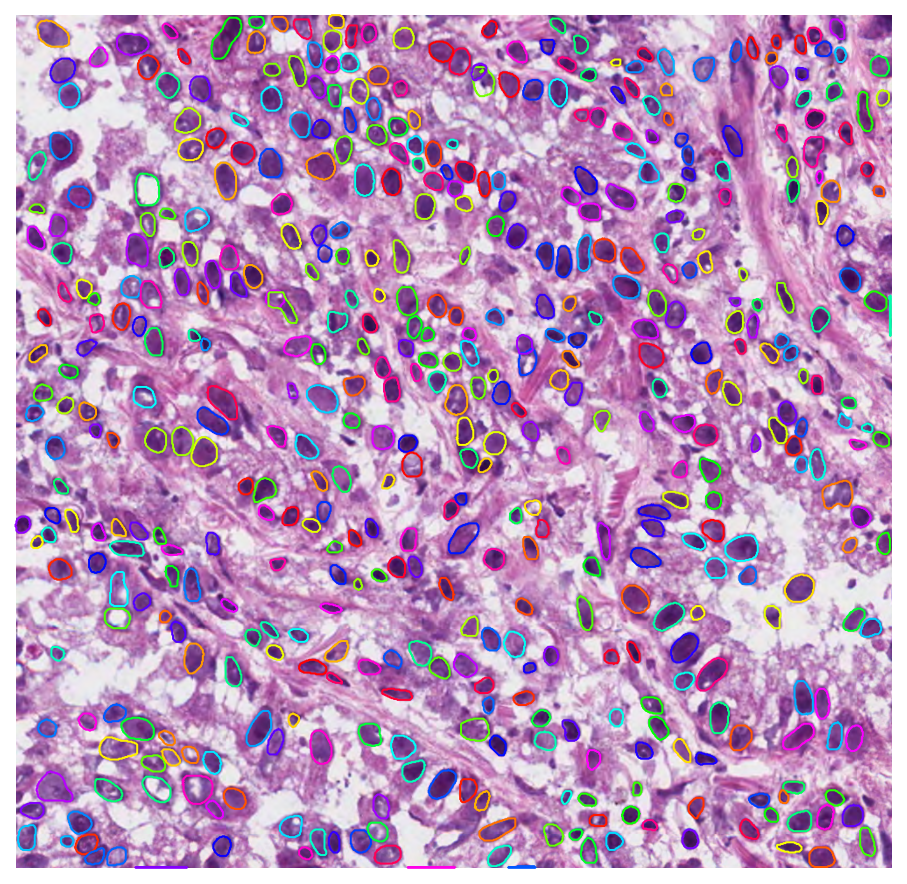

(0.6072168486868494, 0.5921192119518741)


In [7]:
#source = "TCGA-HT-8564-01Z-00-DX1"
#_id = dataset.image_from_source_map["Monuseg.{}".format(source)]
_id = 2
image = dataset.load_image(_id)

#detect works on a list of images, returns a dict with rois, masks, class ids, and scores
print("Running detection...")
r = model.detect([image], verbose = 1)
print("Done detecting...")
# Visualize results
r = r[0]
print(r["masks"].shape)
visualize.display_instances(image[:,:,0:3], r['rois'], r['masks'], r['class_ids'], 
                            ["BG", ""], r['scores'], use_captions=False, show_mask = False, show_bbox = False)

gt_mask = dataset.load_mask(_id)[0]
print(utils.calc_aji_pq(r["masks"], gt_mask))


image ID: Monuseg.TCGA-69-7764-01A-01-TS1 (2) None
Original image shape:  [1000 1000    5]


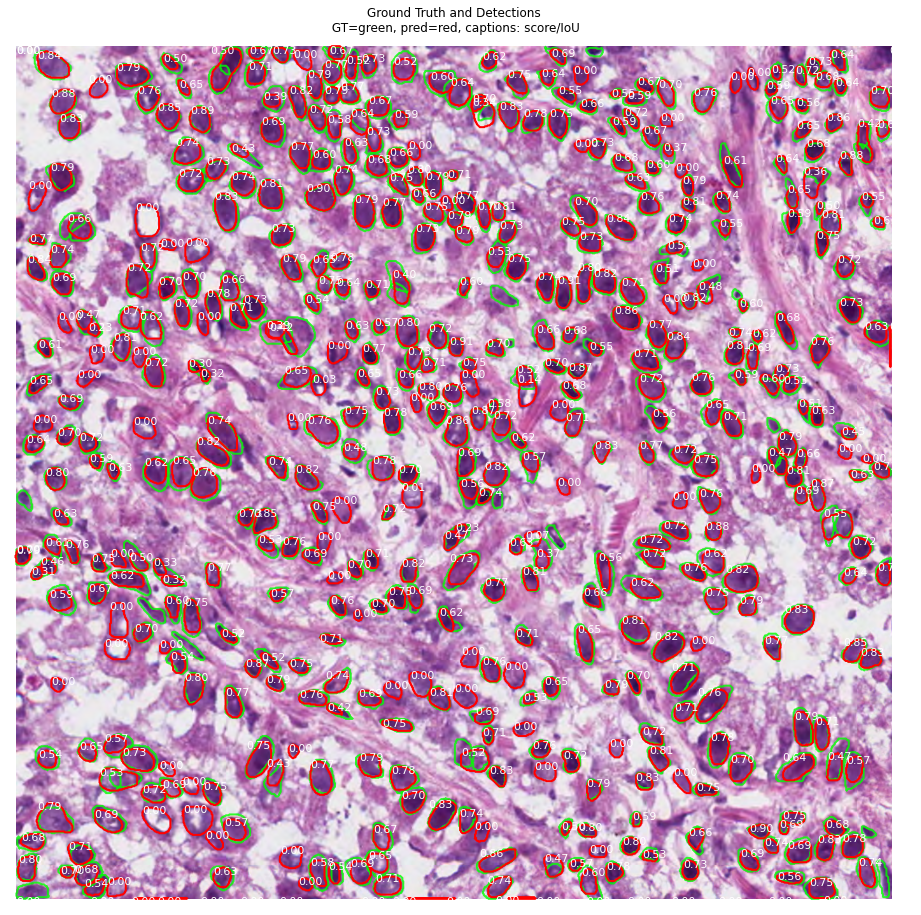

In [9]:
config.IMAGE_RESIZE_MODE = "none"
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, _id, use_mini_mask=False)
info = dataset.image_info[_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], _id, 
                                       dataset.image_reference(_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])


visualize.display_differences(
    image[:,:,0:3],
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    #    r['rois'][idx,:], r['class_ids'][idx], r['scores'][idx], r['masks'][:,:,idx],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False, show_scores=True,
    iou_threshold=0.5, score_threshold=0.5)

## Test Time augmentation

In [10]:
# Set up augmentations:
# 4 Images: Original, flipped Vert, flipped Hori , Hue Saturated

augmentations = []
augmentations.append(A.Compose([A.HorizontalFlip(always_apply=True)], additional_targets={'dist': 'mask', 'Hch':'mask'}))
augmentations.append(A.Compose([A.VerticalFlip(always_apply=True)], additional_targets={'dist': 'mask', 'Hch':'mask'}))
augmentations.append(A.Compose([A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, always_apply=True)], additional_targets={'dist': 'mask', 'Hch':'mask'}))

C:\Users\User\GitHub\Improved Mask R-CNN\mrcnn\utils.py:79: RuntimeWarning: invalid value encountered in true_divide
  iou = intersection / union


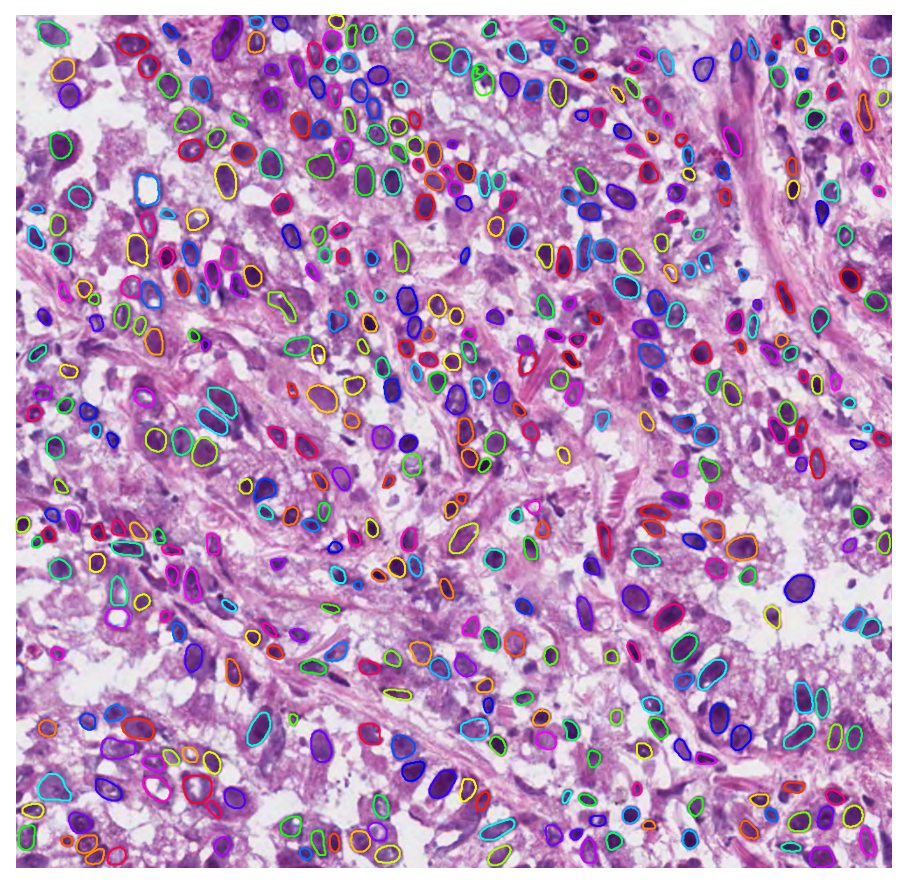

In [12]:
config.IMAGE_RESIZE_MODE = "pad64"
mask = utils.detect_TTA(image, model, augmentations)

visualize.display_instances(image[:, :, 0:3], utils.extract_bboxes(mask), mask, np.ones(mask.shape[-1]), 
                            ["BG", ""], np.ones(mask.shape[-1]), use_captions=False, show_mask = False, show_bbox = False)


## Ensemble

In [58]:
path_list = [
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img020210701T1809\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img0_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img120210701T1627\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img1_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img220210703T1151\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img2_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img320210701T1259\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img3_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img420210701T1145\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img4_0050.h5",
]

model_list = []
for weights_path in path_list:
    with tf.device(DEVICE):
        m = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                                  config=config)
    m.load_weights(weights_path, by_name = True)
    m.curr_dir = os.path.split(weights_path)[0]
    print("Added model at: " +  weights_path)
    model_list.append(m)

Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img020210701T1809\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img0_0050.h5
Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img120210701T1627\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img1_0050.h5
Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img220210703T1151\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img2_0050.h5
Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img320210701T1259\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img3_0050.h5
Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img420210701T1145\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img4_0050.h5
